The purpose of this notebook is to explore the affect of varying the Theiss equation parameters in the Howards East SWI model. Much of the code is from https://transientgroundwaterflow.readthedocs.io/en/latest/TransientFlowToAWell.html
Neil Symington

neil.symington@ga.gov.au

In [18]:
import numpy as np
from scipy.special import expi #scipy exponential integral
import matplotlib.pyplot as plt
import itertools

In [19]:
# Function for W in theiss equation
def W(u):
    return -expi(-u)

# Function for theis equation
def theiss_fn(r, S,Q, kD, t):
    """
    r: radius (m)
    S: storage coefficient
    Q: pumping rate (m**3/day)
    kD: aquifer transmissivity (m**2/day)
    t: time (days)
    returns:
    s: the drawdown at radius r away from the bore
    """
    u = r**2 * S / (4 * kD * t)
    return Q/(4 * np.pi * kD) * W(u)

# Unit conversion
def l_per_sec_to_cubm_per_day(q):
    return  q*((60*60*24)/1000)

In [20]:
# Our first test will be to replicate the figure from the abstract

kD = 390 # HEP4 pump test (Jolly)

S = 2*10**-4 # as above
r = 8000 # distance to RN036538

# step through pump rates

Q = 500 #l/s

# Con
Q = l_per_sec_to_cubm_per_day(Q)

# 190 days
t = 190


print("Drawdown is", np.round(theiss_fn(r,S,Q, kD, t),1), "m ")
print("give a pumping rate of ", Q, "m**3/day for ",  t, " days")

Drawdown is 23.0 m 
give a pumping rate of  43200.0 m**3/day for  190  days


In [21]:
# Now we run the minimise scalar function to find the value of t that causes 23 m of drawdown
# given 500 l/s of pumping

from scipy import optimize

# functoin to optimise
def f(t):
    s = theiss_fn(r,S,Q, kD, t)
    return np.abs(s - 23.0) # Find drawdown of 23m

bounds=(1, 10**20)

result = optimize.minimize_scalar(f, bounds = bounds, method='bounded')
result.success # check if solver was successful

x_min = np.round(result.x,1)
print(x_min, " days") #  

190.3  days


In [23]:
# Now we do this for a range of pumping values of Q

Qs = np.arange(10,1001,10.)

# store time as an array
ts = np.nan*np.ones((len(Qs)), dtype = np.float32)

# iterate through all values of Q
for i, Q in enumerate(Qs):
    Q = l_per_sec_to_cubm_per_day(Q)
    result = optimize.minimize_scalar(f, bounds = bounds,
                                      method='bounded')
    if result.success:
        ts[i] = result.x


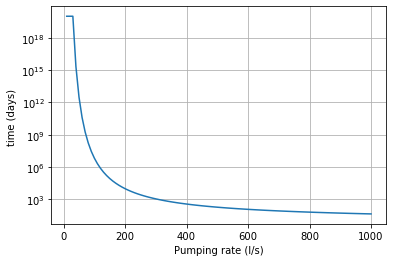

In [24]:
# Now plot the results

plt.plot(Qs, ts)
plt.xlabel('Pumping rate (l/s)')
plt.yscale("log")
plt.ylabel('time (days) ')
plt.grid(True)
plt.show()

However this is just one model given one set of model assumptions. We may investigate the impact of varying these parameters as well. To do this we will do a linear search of model parameters and find which ones give a drawdown of >23 metres in 20 years. 

In [44]:
# Define the parameter ranges for the other parameters

rs = np.arange(4000,8001, 100) # arbitrary worse case scenario is 2km - arbitrary

S = np.logspace(-5,-1)

Qs = np.arange(10,101,1.) # No change

kDs = np.logspace(-1,3)

t = 20*365 # 20 years

# Get the combination of parameters

a = [rs, S, l_per_sec_to_cubm_per_day(Qs),
     kDs, np.array([t])]

params = np.array(list(itertools.product(*a)))

In [45]:
S

array([1.00000000e-05, 1.20679264e-05, 1.45634848e-05, 1.75751062e-05,
       2.12095089e-05, 2.55954792e-05, 3.08884360e-05, 3.72759372e-05,
       4.49843267e-05, 5.42867544e-05, 6.55128557e-05, 7.90604321e-05,
       9.54095476e-05, 1.15139540e-04, 1.38949549e-04, 1.67683294e-04,
       2.02358965e-04, 2.44205309e-04, 2.94705170e-04, 3.55648031e-04,
       4.29193426e-04, 5.17947468e-04, 6.25055193e-04, 7.54312006e-04,
       9.10298178e-04, 1.09854114e-03, 1.32571137e-03, 1.59985872e-03,
       1.93069773e-03, 2.32995181e-03, 2.81176870e-03, 3.39322177e-03,
       4.09491506e-03, 4.94171336e-03, 5.96362332e-03, 7.19685673e-03,
       8.68511374e-03, 1.04811313e-02, 1.26485522e-02, 1.52641797e-02,
       1.84206997e-02, 2.22299648e-02, 2.68269580e-02, 3.23745754e-02,
       3.90693994e-02, 4.71486636e-02, 5.68986603e-02, 6.86648845e-02,
       8.28642773e-02, 1.00000000e-01])

In [46]:
# Now we run the theiss solution for each set of parameters and find the 

s = np.nan * np.ones(shape = len(params), dtype = np.float32)

for i in range(len(params)):
    
    s[i] = theiss_fn(*params[i])

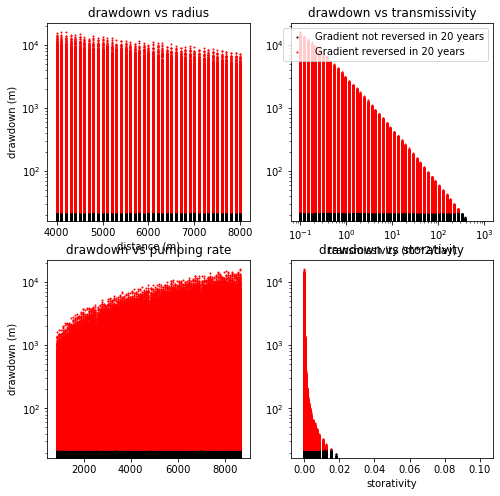

In [47]:
# So for each set of parameters we will plot the values vs the draw down

fig, ax_array = plt.subplots(2,2, figsize = (8,8))

mask = s > 23

ax_array[0,0].scatter(params[:,0][~mask][::11],
                      s[~mask][::11], s = 1,
                     c = 'k', label = 'Gradient not reversed in 20 years')
ax_array[0,0].scatter(params[:,0][mask][::11],
                      s[mask][::11], s = 1,
                     c = 'red', label = 'Gradient reversed in 20 years')
ax_array[0,0].set_title('drawdown vs radius')

ax_array[0,0].set_xlabel('distance (m)')

ax_array[0,1].scatter(params[:,3][~mask][::11],
                      s[~mask][::11], s = 1,
                     c = 'k', label = 'Gradient not reversed in 20 years')

ax_array[0,1].scatter(params[:,3][mask][::11],
                      s[mask][::11], s = 1,
                     c = 'red', label = 'Gradient reversed in 20 years')

ax_array[0,1].set_title('drawdown vs transmissivity')

ax_array[0,1].set_xlabel('transmissivity (m**2/day)')

ax_array[0,1].set_xscale('log')


ax_array[1,0].scatter(params[:,2][~mask][::11],
                      s[~mask][::11], s = 1,
                     c = 'k', label = 'Gradient not reversed in 20 years')

ax_array[1,0].scatter(params[:,2][mask][::11],
                      s[mask][::11], s = 1,

                     c = 'red', label = 'Gradient reversed in 20 years')

ax_array[1,0].set_title('drawdown vs pumping rate')

ax_array[1,1].scatter(params[:,1][~mask][::11],
                      s[~mask][::11], s = 1,
                     c = 'k', label = 'Gradient not reversed in 20 years')

ax_array[1,1].scatter(params[:,1][mask][::11],
                      s[mask][::11], s = 1,

                     c = 'red', label = 'Gradient reversed in 20 years')

ax_array[1,1].set_title('drawdown vs storativity')

ax_array[1,1].set_xlabel('storativity')

ax_array[0,0].set_ylabel('drawdown (m)')
ax_array[1,0].set_ylabel('drawdown (m)')

ax_array[0,0].set_yscale('log')
ax_array[0,1].set_yscale('log')
ax_array[1,0].set_yscale('log')
ax_array[1,1].set_yscale('log')

ax_array[0,1].legend()

plt.show()

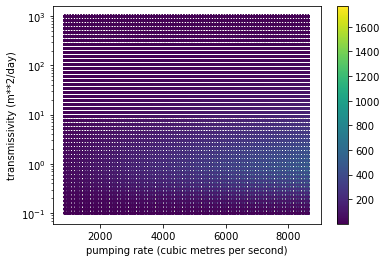

In [17]:
# We can also look at combination of parameters

# 
plt.scatter(params[:,2][::1],
            params[:,3][::1],
            s = 3, c = s[::1],
           cmap = 'viridis')
#plt.scatter(params[:,2][mask][::1],
#            params[:,3][mask][::1],
#            s = 2, c = 'red')
plt.yscale('log')
plt.ylabel('transmissivity (m**2/day)')
plt.xlabel('pumping rate (cubic metres per second)')
plt.colorbar()

plt.show()

In conclusion it look like the the relationship between transmissivity and draw down is non linear. This is likely because it is the product of hydraulic conductivity and aquifer thickness. We may want to split this into thickness and hydraulic K. Also distance looks like it is relatively insensitive to radius.

I hope you have enjoyed this little exercise. The aim was not to say anything about the Howards East but rather to demonstrate how we can quickly and easily build an analytical model and investigate the sensitivity of the parameters.